<a href="https://colab.research.google.com/github/saeedzou/Deep-Learning-Project/blob/dev-saeed/Phase%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# This block downloads and preprocesses the needed data for the project
!git clone https://github.com/XL2248/MSCTD
!cp MSCTD/MSCTD_data/ende/eng* .
!cp MSCTD/MSCTD_data/ende/ima* .
!cp MSCTD/MSCTD_data/ende/sent* .
!rm -rf MSCTD
!pip -q install --upgrade --no-cache-dir gdown
!gdown 1-43sQYxSCsCIxQjOCAS-H4dDI6c2zgi8
!gdown 1k-m84NIuOOTbXjn6ELwj1qBeH7jsN6IO
!gdown 1-0Gg-qpqJpNfLPU7DT81UaFgwu8DVn15
!unzip -q train_ende.zip
!unzip -q dev.zip
!unzip -q test.zip
!mv train_ende train
!mkdir train/image
!mkdir dev/image
!mkdir test/image
!mv train/*.jpg train/image
!mv dev/*.jpg dev/image
!mv test/*.jpg test/image
!mv *train.txt train
!mv *dev.txt dev
!mv *test.txt test

Cloning into 'MSCTD'...
remote: Enumerating objects: 1217, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 1217 (delta 13), reused 7 (delta 3), pack-reused 1190
Receiving objects: 100% (1217/1217), 102.24 MiB | 17.85 MiB/s, done.
Resolving deltas: 100% (616/616), done.
Updating files: 100% (934/934), done.
Downloading...
From: https://drive.google.com/uc?id=1-43sQYxSCsCIxQjOCAS-H4dDI6c2zgi8
To: /content/train_ende.zip
100% 2.90G/2.90G [00:28<00:00, 101MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1k-m84NIuOOTbXjn6ELwj1qBeH7jsN6IO
To: /content/dev.zip
100% 638M/638M [00:06<00:00, 99.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1-0Gg-qpqJpNfLPU7DT81UaFgwu8DVn15
To: /content/test.zip
100% 641M/641M [00:08<00:00, 72.9MB/s]


In [8]:
import numpy as np
import pandas as pd
import re
import nltk
import nltk.tokenize as tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
import string
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
class MSCTD(Dataset):
    """
    :param root: root path of the dataset
    :param split: train, dev, test
    :param image_transform: transform for image
    :param text_transform: transform for text
    :param sentiment_transform: transform for sentiment
    :param has_data: dict, whether the dataset has image, text
    :param text_path: path of the text file
    :param image_path: path of the image folder
    :param sentiment_path: path of the sentiment file
    :param image_index_path: path of the image index file

    :return: combination of image, sentiment, text, image_index

    Example:
    >>> from torchvision import transforms
    >>> image_transform = transforms.Compose([
    >>>     transforms.Resize((640, 1280)),
    >>>     transforms.Lambda(lambda x: x.permute(1, 2, 0))
    >>> ])
    >>> text_transform = None
    >>> sentiment_transform = None
    >>> dataset = MSCTD(root='data', split='train', image_transform=image_transform,
    >>>                 text_transform=text_transform, sentiment_transform=sentiment_transform)
    >>> image, text, sentiment = dataset[0]

    """
    def __init__(self, root, split, image_transform=None, text_transform=None, sentiment_transform=None,
                 has_data={'image': True, 'text': True}, text_path=None, image_path=None, sentiment_path=None,
                 image_index_path=None):
        data_path = os.path.join(root, split)
        default_path = {
            'text': os.path.join(data_path, 'english_' + split + '.txt'),
            'image': os.path.join(data_path, 'image'),
            'sentiment': os.path.join(data_path, 'sentiment_' + split + '.txt'),
            'image_index': os.path.join(data_path, 'image_index_' + split + '.txt'),
        }
        self.image = [] if has_data['image'] else None
        self.image_transform = image_transform
        self.image_path = image_path if image_path else default_path['image']
        self.text = [] if has_data['text'] else None
        self.text_transform = text_transform
        self.text_path = text_path if text_path else default_path['text']
        self.sentiment_path = sentiment_path if sentiment_path else default_path['sentiment']
        self.image_index_path = image_index_path if image_index_path else default_path['image_index']
        self.sentiment = []
        self.image_index = []
        self.sentiment_transform = sentiment_transform
        self.load_data()
        
    def load_data(self):
        self.sentiment = np.loadtxt(self.sentiment_path, dtype=int)
        if self.text is not None:
            with open(self.text_path, 'r') as f:
                self.text = f.readlines()
            self.text = [x.strip() for x in self.text]
        with open(self.image_index_path, 'r') as f:
            data = f.readlines()
        self.image_index = [list(map(int, x[1:-2].split(','))) for x in data]

    def __getitem__(self, index):
        image = None
        text = None
        sentiment = self.sentiment[index]
        if self.image is not None:
            imag_path = os.path.join(self.image_path, str(index)+'.jpg')
            image = read_image(imag_path)
            if self.image_transform:
                image = self.image_transform(image)
        if self.text is not None:
            text = self.text[index]
            if self.text_transform:
                text = self.text_transform(text)
        if self.sentiment_transform:
            sentiment = self.sentiment_transform(sentiment)
        if text is not None and image is not None:
            return image, text, sentiment
        elif text is not None:
            return text, sentiment
        elif image is not None:
            return image, sentiment
        else:
            raise Exception('Either image or text should be not None')

    def __len__(self):
        return len(self.sentiment)

In [147]:
MSCTD_train = MSCTD(root='.', split='train', has_data={'image': False, 'text': True})
MSCTD_dev = MSCTD(root='.', split='dev', has_data={'image': False, 'text': True})
MSCTD_test = MSCTD(root='.', split='test', has_data={'image': False, 'text': True})

In [148]:
def get_wordnet_pos(word):
    """Map POS tag to first character used by WordNetLemmatizer"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def text_preprocessor(dataset):
      # preprocess text
      dataset.text = [preprocess_text(text) for text in dataset.text]

def preprocess_text(text):
      # Replace contractions with original text
  text = re.sub(r'(\b[Aa]in\'t\b)', "am not", text)
  text = re.sub(r'(\b[Hh]a\'t\b)', "has", text)
  text = re.sub(r'(\b[Ii]\'m\b)', "i am", text)
  # convert 's to is
  text = re.sub(r'(\b\'s\b)', " is", text)
  text = re.sub(r'(\b\'re\b)', " are", text)
  text = re.sub(r'(\b\'ve\b)', " have", text)
  text = re.sub(r'(\b\'d\b)', " would", text)
  text = re.sub(r'(\b\'ll\b)', " will", text)
  text = re.sub(r'(\b[Ss]han\'t\b)', "shall not", text)
  text = re.sub(r'(\b[Ww]on\'t\b)', "will not", text)
  text = re.sub(r'(\b[Ww]ouldn\'t\b)', "would not", text)
  text = re.sub(r'(\b[Dd]on\'t\b)', "do not", text)
  text = re.sub(r'(\b[Cc]an\'t\b)', "can not", text)
  text = re.sub(r'(\b[Ii]s\'nt\b)', "is not", text)
  text = re.sub(r'(\b[Ww]eren\'t\b)', "were not", text)
  text = re.sub(r'(\b[Hh]aven\'t\b)', "have not", text)
  text = re.sub(r'(\b[Hh]adn\'t\b)', "had not", text)
  text = re.sub(r'(\b[Hh]asn\'t\b)', "has not", text)
  text = re.sub(r'(\b[Hh]adn\'t\b)', "had not", text)
  text = re.sub(r'(\b[Dd]idn\'t\b)', "did not", text)

  # Remove punctuation
  text = text.translate(str.maketrans("", "", string.punctuation))

  # Convert to lowercase
  text = text.lower()

  # Tokenize text
  tokens = word_tokenize(text)

  # Remove stop words
  # tokens = [token for token in tokens if token not in stop_words]
  # Remove numbers
  tokens = [token for token in tokens if token.isalpha()]

  # Lemmatize tokens
  tokens = [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]

  return ' '.join(tokens)

# Test the TextPreprocessor
text_preprocessor(MSCTD_train)
text_preprocessor(MSCTD_dev)
text_preprocessor(MSCTD_test)

In [149]:
class TFIDFProcessor:
    def __init__(self, dataset):
        self.dataset = dataset
        self.tfidf = TfidfVectorizer()
        self.tfidf_matrix = None

    def fit(self):
        # Get all the captions from the dataset
        captions = [caption for caption, _ in self.dataset]

        # Fit the TF-IDF model on the captions
        self.tfidf_matrix = self.tfidf.fit_transform(captions)

    def transform(self, caption):
        # Transform the input caption using the fitted TF-IDF model
        tfidf_vector = self.tfidf.transform([caption])

        # Convert the resulting sparse matrix to a dense numpy array
        return np.array(tfidf_vector.todense()).squeeze(0)

    def __getitem__(self, index):
        # Get the caption and sentiment from the dataset
        caption, sentiment = self.dataset[index]

        # Transform the caption using the TF-IDF model
        tfidf_vector = self.transform(caption)

        return tfidf_vector, sentiment

In [150]:
tfidf_processor = TFIDFProcessor(MSCTD_train)
tfidf_processor.fit()

In [151]:
tfidf_processor.tfidf.get_feature_names_out()

array(['aa', 'aand', 'aaron', ..., 'zuckerberg', 'zup', 'zz'],
      dtype=object)

In [183]:
class TFIDFDataSet:
    def __init__(self, dataset, tfidf_processor):
        self.dataset = dataset
        self.tfidf_processor = tfidf_processor
        
    def __getitem__(self, index):
        # Get the caption and sentiment from the MSCTD dataset
        caption, sentiment = self.dataset[index]

        # Convert the caption to a TF-IDF vector using the TFIDFProcessor
        tfidf_vector = self.tfidf_processor.transform(caption)

        # Return the TF-IDF vector and sentiment
        return torch.from_numpy(tfidf_vector.astype(np.float32)), torch.from_numpy(np.array(sentiment))

    def __len__(self):
        return len(self.dataset)

In [184]:
train_dataset = TFIDFDataSet(MSCTD_train, tfidf_processor)
dev_dataset = TFIDFDataSet(MSCTD_dev, tfidf_processor)
test_dataset = TFIDFDataSet(MSCTD_dev, tfidf_processor)

In [198]:
# data loader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [216]:
class MLPClassifier(nn.Module):
  def __init__(self, input_size, num_classes):
    super(MLPClassifier, self).__init__()
    self.linear = nn.Linear(input_size, num_classes)

  def forward(self, x):
    return self.linear(x)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_size = len(tfidf_processor.tfidf.get_feature_names_out())
num_classes = 3
model = MLPClassifier(input_size, num_classes)
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [217]:
# Train the model for 10 epochs
train_loss = []
dev_loss = []
train_acc = []
dev_acc = []
for epoch in range(10):
    running_loss = 0.0
    running_acc = 0.0
    for i, (tfidf, sentiment) in enumerate(train_loader):
        tfidf = tfidf.to(device)
        sentiment = sentiment.to(device)
        
        outputs = model(tfidf)
        # if i > 630:
        #   print(tfidf.shape, sentiment.shape, outputs.shape)
        loss = loss_fn(outputs, sentiment)
        # backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_acc += (torch.argmax(outputs, dim=1) == sentiment).sum().item()
    train_loss.append(running_loss / len(train_loader))
    train_acc.append(running_acc / len(train_loader.dataset))
    print(f'Epoch {epoch+1}/{10}, Training Loss: {train_loss[-1]:.4f}, Training Accuracy: {train_acc[-1]:.4f}')
    # Evaluate on the dev set
    with torch.no_grad():
        running_loss = 0.0
        running_acc = 0.0
        for i, (tfidf, sentiment) in enumerate(dev_loader):
            tfidf = tfidf.to(device)
            sentiment = sentiment.to(device)
            outputs = model(tfidf)
            loss = loss_fn(outputs, sentiment)
            running_loss += loss.item()
            running_acc += (torch.argmax(outputs, dim=1) == sentiment).sum().item()
        dev_loss.append(running_loss / len(dev_loader))
        dev_acc.append(running_acc / len(dev_loader.dataset))
        print(f'Epoch {epoch+1}/{10}, Dev Loss: {dev_loss[-1]:.4f}, Dev Accuracy: {dev_acc[-1]:.4f}')
        

    

Epoch 1/10, Training Loss: 1.0715, Training Accuracy: 0.4122
Epoch 1/10, Dev Loss: 1.0638, Dev Accuracy: 0.4175
Epoch 2/10, Training Loss: 1.0286, Training Accuracy: 0.5189
Epoch 2/10, Dev Loss: 1.0414, Dev Accuracy: 0.4705
Epoch 3/10, Training Loss: 0.9944, Training Accuracy: 0.5756
Epoch 3/10, Dev Loss: 1.0247, Dev Accuracy: 0.4938
Epoch 4/10, Training Loss: 0.9660, Training Accuracy: 0.6038
Epoch 4/10, Dev Loss: 1.0116, Dev Accuracy: 0.5023
Epoch 5/10, Training Loss: 0.9419, Training Accuracy: 0.6206
Epoch 5/10, Dev Loss: 1.0016, Dev Accuracy: 0.5078
Epoch 6/10, Training Loss: 0.9209, Training Accuracy: 0.6369
Epoch 6/10, Dev Loss: 0.9940, Dev Accuracy: 0.5110
Epoch 7/10, Training Loss: 0.9023, Training Accuracy: 0.6469
Epoch 7/10, Dev Loss: 0.9894, Dev Accuracy: 0.5133
Epoch 8/10, Training Loss: 0.8856, Training Accuracy: 0.6551
Epoch 8/10, Dev Loss: 0.9851, Dev Accuracy: 0.5151
Epoch 9/10, Training Loss: 0.8706, Training Accuracy: 0.6631
Epoch 9/10, Dev Loss: 0.9822, Dev Accuracy:

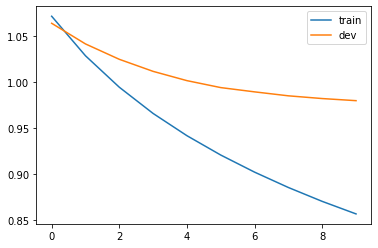

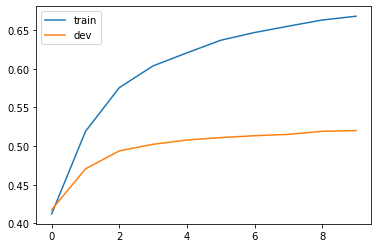

In [218]:
import matplotlib.pyplot as plt
plt.plot(train_loss, label='train')
plt.plot(dev_loss, label='dev')
plt.legend()
plt.show()
plt.plot(train_acc, label='train')
plt.plot(dev_acc, label='dev')
plt.legend()
plt.show()

In [219]:
# evaluate on the test set
with torch.no_grad():
    running_loss = 0.0
    running_acc = 0.0
    for i, (tfidf, sentiment) in enumerate(test_loader):
        tfidf = tfidf.to(device)
        sentiment = sentiment.to(device)
        outputs = model(tfidf)
        loss = loss_fn(outputs, sentiment)
        running_loss += loss.item()
        running_acc += (torch.argmax(outputs, dim=1) == sentiment).sum().item()
    test_loss = running_loss / len(test_loader)
    test_acc = running_acc / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}')

Test Loss: 0.9794, Test Accuracy: 0.5200
